In [4]:
import torch
import pickle

In [2]:
my_model = torch.load('KG versions/V4/Uniform/G1/TransH1/trained_model.pkl')


In [7]:
# torch.save(my_model, 'tensor.pkl', pickle_protocol=4)  #, _use_new_zipfile_serialization=True
with open('tensor_2.pkl', 'wb') as pfile:
    pickle.dump(my_model, pfile, protocol=3)


In [93]:
from pykeen.triples import TriplesFactory

from pykeen.pipeline import pipeline
from pykeen.models import predict
import pandas as pd
import numpy as np
import statistics
from scipy.ndimage import gaussian_filter1d
import math
import sys
import torch


def select_graph(n):
    # th_lowEffect = 32.59991399904  # means 308
    # th_effective = 67.4008600096  # means 149

    # th_lowEffect = 30.645161290322577 # means 430
    # th_effective = 69.35483870967742 # means 190
    th_lowEffect = 27.19266055 # means 399
    th_effective = 72.80733945 # means 149
    #n_sample = 124
    #n_sample_effective = [38, 34, 40, 35, 43]
    #n_sample_lowEffect = [n_sample - x for x in n_sample_effective]
    #th_effective = [1 - x / n_sample for x in n_sample_effective]
    #th_lowEffect = [1 - x / n_sample for x in n_sample_lowEffect]
    
    if n == 1:
        file_name = 'config_g1.csv'
    elif n == 2:
        file_name = 'config_g2.csv'
    else:
        file_name = 'config_g3.csv'
    return file_name, n, th_lowEffect, th_effective


# # Load Train data
def load_dataset(path, name):
    triple_data = open(path + name).read().strip()
    data = np.array([triple.split('\t') for triple in triple_data.split('\n')])
    tf_data = TriplesFactory.from_labeled_triples(triples=data)
    return tf_data, triple_data


def create_model(tf_training, tf_testing, embedding, n_epoch, path, fold):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,  # 'TransE',  #'RotatE'
        # stopper='early',
        # stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.002),
        # training_loop='sLCWA',
        # negative_sampler='bernoulli',
        negative_sampler_kwargs=dict(
        filtered=True,
        ),
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='gpu',
    )
    model = results.model
    results.save_to_directory(path + embedding + str(fold))
    return model, results


# # Predict links (Head prediction)
def predict_heads(model, prop, obj, tf_testing):  # triples_factory=results.training
    predicted_heads_df = predict.get_head_prediction_df(model, prop, obj, triples_factory=tf_testing)
    return predicted_heads_df


# Filter the prediction by the head 'treatment_drug:treatment'. We are not interested in predict another links
def filter_prediction(predicted_heads_df, constraint):
    predicted_heads_df = predicted_heads_df[predicted_heads_df.head_label.str.contains(constraint)]
    return predicted_heads_df


def save_statistics(path, line):
    with open(path + 'results_threshold.csv', 'a') as file:
        file.write(line)


def get_config(config_file):
    config = pd.read_csv(config_file, delimiter=";")  # 'config_G1.csv'
    models = config.model.values[0].split(',')
    epochs = config.epochs.values[0]
    k = config.k_fold.values[0]
    path = config.path.values[0]
    graph_name = config.graph_name.values[0]
    return models, epochs, k, path, graph_name


def load_testset_classes(path, name):
    r = pd.read_csv(path + name, delimiter='\t', header=None)
    r.columns = ['head_label', 'p', 'o']
    r['o'] = r['o'].str.replace(' .', '')
    r_tox = r.loc[r.o == 'ex:effective']
    head_tox = list(r_tox.head_label)
    r_eff = r.loc[r.o == 'ex:low_effect']
    head_eff = list(r_eff.head_label)
    return head_tox, head_eff


def adding_testset(predicted_heads, head):
    predicted_heads.loc[predicted_heads.head_label.isin(head), 'in_training'] = True

    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def get_threshold(predicted_heads, percentile):
    score_values = predicted_heads.score.values
    threshold = np.percentile(score_values, percentile)
    threshold_index = predicted_heads.loc[predicted_heads.score > threshold].shape[0]
    return threshold, threshold_index


def get_inflection_point(score_values):
    # standard deviation
    stdev = statistics.stdev(score_values)
    # smooth
    smooth = gaussian_filter1d(score_values, stdev)
    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))
    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    if len(infls) == 1:
        return infls[0]
    if len(infls) == 0:
        return len(score_values)
    # middle inflection point
    m_infls = infls[math.ceil(len(infls) / 2)]
    return m_infls


def get_precision(predicted_heads, inflection_index):
    tp_fp = predicted_heads.iloc[0:inflection_index + 1]
    tp = tp_fp.loc[tp_fp.in_training == True].shape[0]
    prec = tp / tp_fp.shape[0]
    return prec, tp


def get_recall(predicted_heads, tp):
    tp_fn = predicted_heads.loc[predicted_heads.in_training == True].shape[0]
    rec = tp / tp_fn
    return rec


def get_f_measure(precision, recall):
    f_measure = 2 * (precision * recall) / (precision + recall)
    return f_measure


def reset_index(predicted_heads):
    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def main(*args):
    file_name, n, th_dec_eff, th_eff = select_graph(int(args[0]))
    models, epochs, k, path, graph_name = get_config(file_name)
    models = ['TransE','TransH','RotatE','TransD', 'HolE', 'TransR', 'ERMLP', 'QuatE', 'RESCAL', 'SE', 'UM']
    for m in models:
        precision = 0
        recall = 0
        f_measure = 0
        for i in range(0, k):
            tf_training, triple_train = load_dataset(path, 'train_' + str(i + 1) + '.ttl')
            tf_testing, triple_test = load_dataset(path, 'test_' + str(i + 1) + '.ttl')
            #model, results = create_model(tf_training, tf_testing, m, epochs, path, i + 1)
            model = torch.load(path + m + str(i + 1) + '/trained_model.pkl', map_location='cpu') # , map_location='cpu'
            predicted_heads_eff = predict_heads(model, 'ex:belong_to', 'ex:effective', tf_testing) #tf_training
            predicted_heads_dec_eff = predict_heads(model, 'ex:belong_to', 'ex:low_effect',tf_testing)

            threshold, threshold_index = get_threshold(predicted_heads_dec_eff, th_dec_eff)
            precision_dec_eff, tp = get_precision(predicted_heads_dec_eff, threshold_index)
            recall_dec_eff = get_recall(predicted_heads_dec_eff, tp)
            f_measure_dec_eff = 0
            if (precision_dec_eff + recall_dec_eff) > 0:
                f_measure_dec_eff = get_f_measure(precision_dec_eff, recall_dec_eff)
            
            
            threshold, threshold_index = get_threshold(predicted_heads_eff, th_eff)
            precision_eff, tp = get_precision(predicted_heads_eff, threshold_index)
            recall_eff = get_recall(predicted_heads_eff, tp)
            f_measure_eff = 0
            if (precision_eff + recall_eff) > 0:
                f_measure_eff = get_f_measure(precision_eff, recall_eff)
            
            
            precision += (precision_eff + precision_dec_eff) / 2
            recall += (recall_eff + recall_dec_eff) / 2
            f_measure += (f_measure_eff + f_measure_dec_eff) / 2
            # print(precision, recall, f_measure)

        avg_precision = precision / k
        avg_recall = recall / k
        avg_f_measure = f_measure / k
        line = m + ';' + str(avg_precision) + ';' + str(avg_recall) + ';' + str(avg_f_measure) + '\n'
        save_statistics(path, line)
        print(line)
# 0.44573789756320786
# 0.5070971862550617

In [51]:
main(1)

TransE;0.5225413060582218;0.5433103278366651;0.5317875606809286

TransH;0.5672969118804092;0.5914836901749927;0.5779272668774993

TransD;0.5200506490952005;0.5400769365652991;0.5289998413614738

HolE;0.46472511801730915;0.47779258372970085;0.47054422178949185

ERMLP;0.4518981117230528;0.46355227164128754;0.45717928342527625

QuatE;0.4788994885916601;0.4973898078838871;0.4872581904816637

RESCAL;0.5008236624704956;0.5172603359802216;0.5081410555461148

SE;0.4882990755310779;0.5073459813741562;0.49673434930452826

UM;0.41869345003933905;0.42893869683988095;0.4234492541447462



In [82]:
import json
from matplotlib import pyplot as plt

def load_results(path):
    # Opening JSON file
    f = open(path)
    # returns JSON object as
    # a dictionary
    results = json.load(f)
    return results

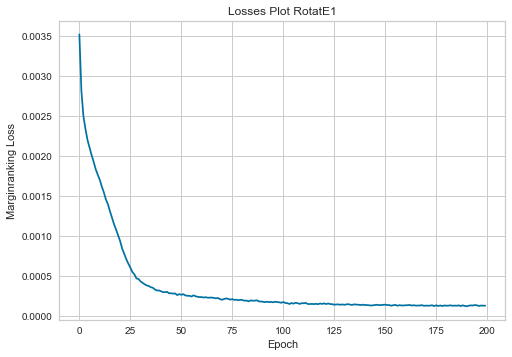

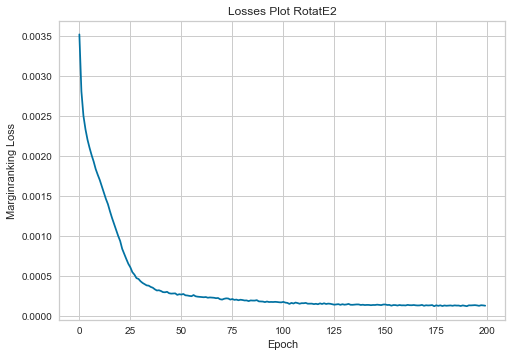

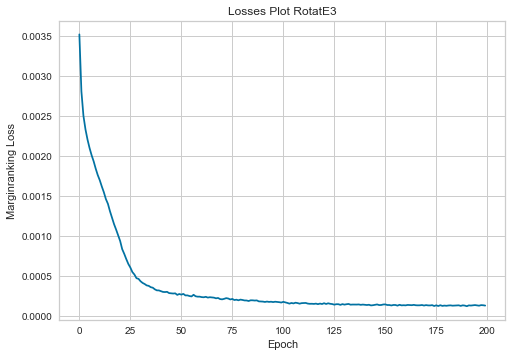

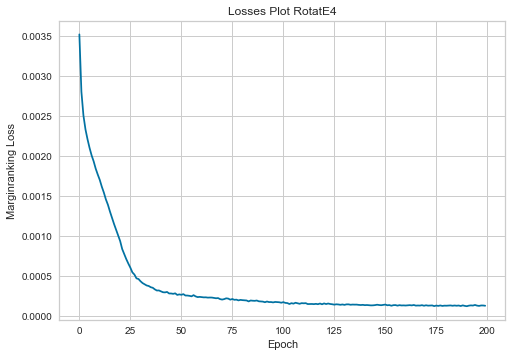

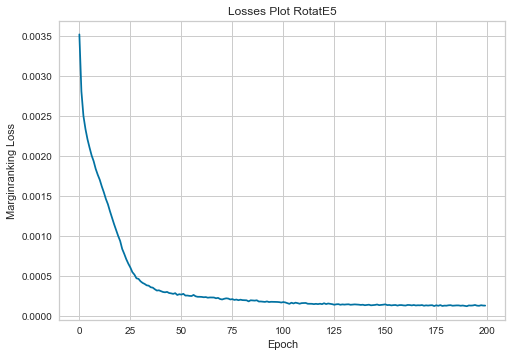

In [83]:
file_name, n, th_dec_eff, th_eff = select_graph(2)
models, epochs, k, path, graph_name = get_config(file_name)
models=['RotatE']
for m in models:
    for i in range(0, k):
        results = load_results(path + m + str(i + 1) + '/results.json')
        plt.plot(results['losses'])
        plt.xlabel("Epoch")
        plt.ylabel("Marginranking Loss")
        plt.title("Losses Plot " + m + str(i + 1))
        plt.show()
        plt.close()

In [123]:
import matplotlib.pyplot as plt
def plot_score_value(score_values, response, th, min_s, max_s, n):
    x1, y1 = [th, th], [min_s, max_s]
    fig, ax = plt.subplots()
    plt.plot(score_values, label='score')
    plt.plot(x1, y1, label='cut-off', color='green')
    plt.xlabel("Entities")
    plt.ylabel("Score")
    plt.grid(False)
    ax.legend(loc='upper center', fontsize=16)
    #plt.title(title)
    #plt.savefig(fname=title + ".png", format='png', bbox_inches='tight', dpi=300)
    #plt.savefig(fname=title + ".png", format='png', bbox_inches='tight', transparent=True)
    if n == 1:
        plt.title('Score values of treatment response ' + response +' in ' + '${\cal{T\_KG}}_{basic}$',
                  loc='left', fontsize=16)
    elif n == 2:
        plt.title('Score values of treatment response ' + response +' in ' + '$\cal{T\_KG}$',
                  loc='left', fontsize=16)
    else:
        plt.title('Score values of treatment response ' + response +' in ' + '${\cal{T\_KG}}_{random}$',
                  loc='left', fontsize=16)
    #plt.savefig(fname='Plots/KG'+str(n)+'_Score_' + response + '_TransH.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

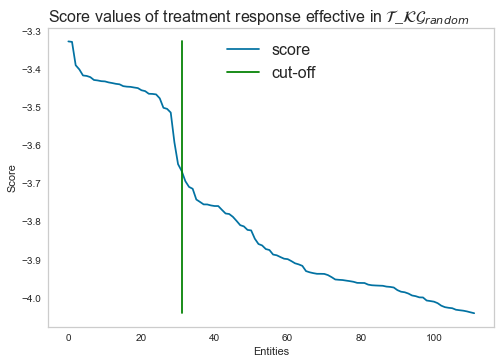

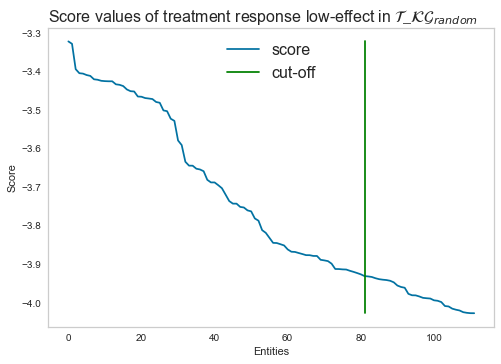

In [131]:
file_name, n, th_dec_eff, th_eff = select_graph(3)
models, epochs, k, path, graph_name = get_config(file_name)
path = 'KG versions/V3.1/Bernoulli/G'+str(n)+'/'

for m in ['TransH']: #models:  RotatE   TransH
    for i in range(0, k):
        tf_training, triple_train = load_dataset(path, 'train_' + str(i + 1) + '.ttl')
        tf_testing, triple_test = load_dataset(path, 'test_' + str(i + 1) + '.ttl')
        model = torch.load(path + m + str(i + 1) + '/trained_model.pkl', map_location='cpu')
        predicted_heads_eff = predict_heads(model, 'ex:belong_to', 'ex:effective', tf_testing) #tf_training
        predicted_heads_dec_eff = predict_heads(model, 'ex:belong_to', 'ex:low_effect', tf_testing)
        #predicted_heads_eff = filter_prediction(predicted_heads_eff, '<http://example/Treatment/treatment')
        #predicted_heads_dec_eff = filter_prediction(predicted_heads_dec_eff, '<http://example/Treatment/treatment')

        #head_eff, head_dec_eff = load_testset_classes(path, 'test_' + str(i + 1) + '.ttl')  # graph_name
        #predicted_heads_eff = adding_testset(predicted_heads_eff, head_eff)
        #predicted_heads_dec_eff = adding_testset(predicted_heads_dec_eff, head_dec_eff)        
    
        
        score_values = predicted_heads_eff.score.values
        threshold, threshold_index = get_threshold(predicted_heads_eff, th_eff)
        plot_score_value(score_values, 'effective', threshold_index,
                         min(score_values), max(score_values), n)
        
        score_values = predicted_heads_dec_eff.score.values
        threshold, threshold_index = get_threshold(predicted_heads_dec_eff, th_dec_eff)
        plot_score_value(score_values, 'low-effect', threshold_index,
                         min(score_values), max(score_values), n)
        break

In [2]:
import Auxiliary

# Unsupervised Learning¶

####  Save Learned Embeddings

In [171]:
file_name, n, th_dec_eff, th_eff = select_graph(3)
models, epochs, k, path, graph_name = get_config(file_name)
m = 'ERMLP'  #RotatE
fold=1

# path = 'KG versions/'+path
path = 'KG versions/V3.1/Bernoulli/G'+str(n)+'/'
print(path)
#path = '../../Experiments_cancer_treatment/G2/'
model = torch.load(path + m + str(fold) + '/trained_model.pkl', map_location='cpu')


#model = torch.load('G/QuatE5/trained_model.pkl', map_location='cpu') #QuatE1
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model)

KG versions/V3.1/Bernoulli/G3/


### Computing clusters of the predicted heads by the model. Visualize PCA Projection to 2D

##### Creating dataframe with the embeddings predicted entities

In [172]:
tf_training, triple_train = load_dataset(path, 'train_' + str(fold) + '.ttl')
tf_testing, triple_test = load_dataset(path, 'test_' + str(fold) + '.ttl')
predicted_heads_eff = predict_heads(model, 'ex:belong_to', 'ex:effective', tf_training)  #tf_training, tf_training
predicted_heads_dec_eff = predict_heads(model, 'ex:belong_to', 'ex:low_effect',tf_training)
predicted_heads_eff = filter_prediction(predicted_heads_eff, '<http://example/Treatment/treatment')
predicted_heads_dec_eff = filter_prediction(predicted_heads_dec_eff, '<http://example/Treatment/treatment')

head_eff, head_dec_eff = load_testset_classes(path, 'test_' + str(fold) + '.ttl')  # graph_name
predicted_heads_eff = adding_testset(predicted_heads_eff, head_eff)
predicted_heads_dec_eff = adding_testset(predicted_heads_dec_eff, head_dec_eff)

df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, predicted_heads_eff,
                                                                      tf_training)

C:\Users\rivasa\Anaconda3\lib\site-packages\pykeen\nn\representation.py:367: UserWarning: Directly use Embedding.shape instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.shape instead of num_embeddings.")
C:\Users\rivasa\AppData\Local\Temp/ipykernel_28492/3417892884.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  r['o'] = r['o'].str.replace(' .', '')


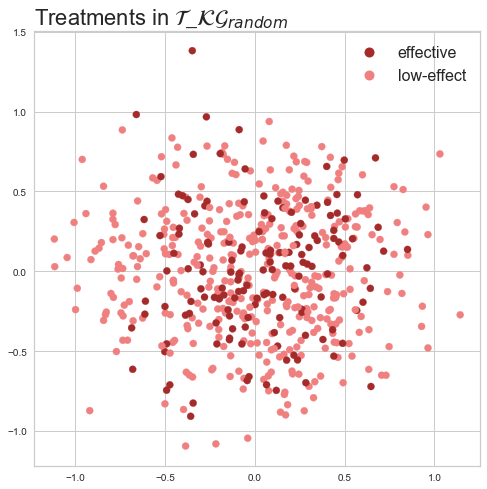

In [173]:
Auxiliary.plot_treatment(new_df, predicted_heads_eff, predicted_heads_dec_eff, n)

In [174]:
new_df.to_csv('dataset/embedding_ERMLP'+str(fold)+'_g3.csv', index=None)
#new_df.to_csv(path + 'embedding_transH'+str(fold)+'_g2.csv', index=None)

#### Select the optimal number of clusters

#### elbow: By default, the distortion score is computed, the sum of square distances from each point to its assigned center.

C:\Users\rivasa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


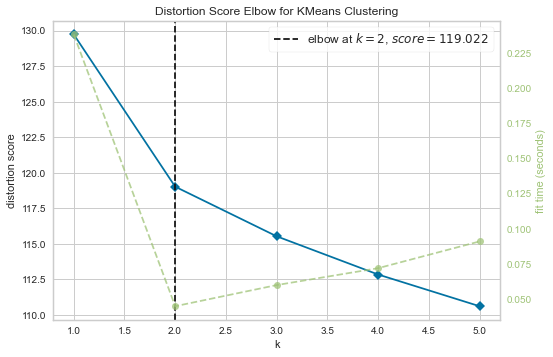

In [23]:
num_cls = Auxiliary.elbow_KMeans(df_predicted_entities, 1, 6, n)

### Visualize PCA Projection to 2D

C:\Users\rivasa\GitHub\Cancer_treatment\Embeddings\Auxiliary.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster'] = kmeans.fit_predict(new_df)
C:\Users\rivasa\GitHub\Cancer_treatment\Embeddings\Auxiliary.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['c'] = new_df.cluster.map(color_dictionary)


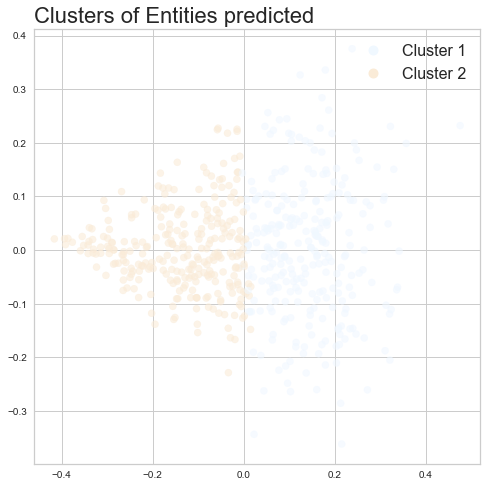

In [24]:
Auxiliary.plot_cluster(num_cls, df_predicted_entities, n)

ValueError: could not convert string to float: '<http://example/Treatment/treatment0>'

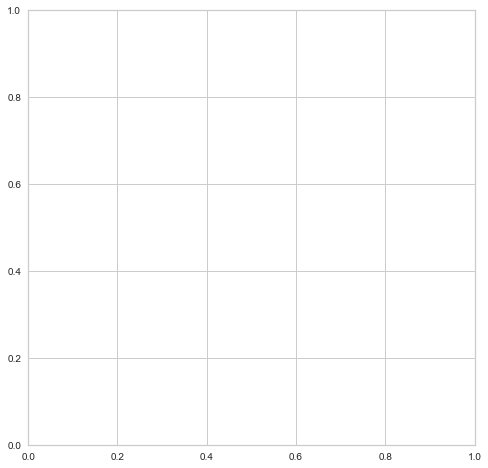

In [30]:
Auxiliary.plot_treatment(new_df, predicted_heads_eff, predicted_heads_dec_eff, n)

In [67]:
import matplotlib.colors as colors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def plot_treatment(new_df, predicted_heads_tox, predicted_heads_eff, n):
    
    toxicity = list(predicted_heads_tox.loc[predicted_heads_tox.in_training==True].head_label)
    effect = list(predicted_heads_eff.loc[predicted_heads_eff.in_training==True].head_label)
    #new_df['cls'] = 'safe'
    new_df.loc[new_df.target.isin(toxicity), 'cls'] = 'effective'
    new_df.loc[new_df.target.isin(effect), 'cls'] = 'decrease_effectiveness'
    X = new_df.iloc[:, :-2].copy()
    
    # define and map colors
    col = list(colors.cnames.values())
    #col = col[:2]
    col = [col[9], col[3]]
    index = ['effective', 'decrease_effectiveness']
    color_dictionary = dict(zip(index, col))
    new_df['c'] = new_df.cls.map(color_dictionary)
    #####PLOT#####
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # plot data
    pca = PCA(n_components=2).fit(X)
    pca_c = pca.transform(X)
    plt.scatter(pca_c[:, 0], pca_c[:, 1], c=new_df.c, alpha=0.6, s=50)

    # create a list of legend elemntes
    ## markers / records
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                              markerfacecolor=mcolor, markersize=10) for key, mcolor in color_dictionary.items()]
    # plot legend
    plt.legend(handles=legend_elements, loc='upper right', fontsize=16)
    # title and labels
    plt.title('Treatments in KG ' + str(n), loc='left', fontsize=22)
    plt.savefig(fname='PCA_KG_' + str(n) + ".png", format='png', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

In [48]:
col = list(colors.cnames.values())
col = col[:3]
index = ['safe', 'increase_toxicity', 'decrease_effectiveness']
color_dictionary = dict(zip(index, col))
for i, mcolor in color_dictionary.items():
    print(i, mcolor)

safe #F0F8FF
increase_toxicity #FAEBD7
decrease_effectiveness #00FFFF


In [48]:
list(predicted_heads_tox.loc[predicted_heads_tox.in_training==True].head_label)
list(predicted_heads_eff.loc[predicted_heads_eff.in_training==True].head_label)

['<http://example/Treatment/treatment4851>',
 '<http://example/Treatment/treatment5204>',
 '<http://example/Treatment/treatment5502>',
 '<http://example/Treatment/treatment5109>',
 '<http://example/Treatment/treatment5514>',
 '<http://example/Treatment/treatment5108>',
 '<http://example/Treatment/treatment5383>',
 '<http://example/Treatment/treatment4507>',
 '<http://example/Treatment/treatment4893>',
 '<http://example/Treatment/treatment5101>',
 '<http://example/Treatment/treatment5690>',
 '<http://example/Treatment/treatment5016>',
 '<http://example/Treatment/treatment5486>',
 '<http://example/Treatment/treatment5362>',
 '<http://example/Treatment/treatment5024>',
 '<http://example/Treatment/treatment4928>',
 '<http://example/Treatment/treatment5920>',
 '<http://example/Treatment/treatment5113>',
 '<http://example/Treatment/treatment5733>',
 '<http://example/Treatment/treatment4567>',
 '<http://example/Treatment/treatment5881>',
 '<http://example/Treatment/treatment4674>',
 '<http://

In [70]:

df = pd.DataFrame(entity_embedding_tensor.cpu().detach().numpy())
df['target'] = list(tf_training.entity_to_id)
new_df = df.loc[df.target.isin(list(predicted_heads_tox.head_label))]

toxicity = list(predicted_heads_tox.loc[predicted_heads_tox.in_training==True].head_label)
effect = list(predicted_heads_eff.loc[predicted_heads_eff.in_training==True].head_label)
new_df['c'] = 'blue' #'safe'
new_df.loc[new_df.target.isin(toxicity), 'c'] = 'red' #'toxicity'
new_df.loc[new_df.target.isin(effect), 'c'] = 'yellow' #'effect'
new_df
#new_df.iloc[:, :-2]

/tmp/ipykernel_32617/3141960324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['c'] = 'blue' #'safe'
/home/rivas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,target,c
2837,0.000219,-0.058894,-0.015694,0.213420,0.403411,0.040770,0.008484,0.004670,-0.008463,0.097463,...,0.012038,0.025622,-0.001184,0.022374,0.015173,0.318036,0.006205,0.004144,<http://example/Treatment/treatment10000>,blue
2838,-0.004041,0.002142,0.002640,0.222867,0.411089,-0.029141,-0.041949,0.023273,0.000669,0.118831,...,-0.008621,-0.028181,0.009605,-0.050462,-0.002180,0.314961,-0.003099,0.017523,<http://example/Treatment/treatment1000>,red
2839,-0.006182,-0.004631,-0.013187,0.218898,0.424609,-0.027705,-0.006088,-0.009228,-0.005684,0.062557,...,-0.001592,0.013766,-0.004275,-0.017894,-0.008566,0.338343,0.006011,-0.005985,<http://example/Treatment/treatment1001>,red
2840,0.012108,0.019685,0.041001,0.233183,0.425174,-0.052253,0.002380,0.019874,0.043172,0.094841,...,0.052314,-0.035340,0.045936,-0.058550,0.003056,0.318014,-0.033633,0.048866,<http://example/Treatment/treatment1002>,red
2841,0.020076,-0.025943,0.027955,0.234314,0.437074,-0.042519,-0.015113,0.028813,-0.009288,0.098615,...,0.057211,-0.031642,0.011815,-0.052276,0.031863,0.330525,-0.023570,-0.017341,<http://example/Treatment/treatment1003>,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12832,-0.008270,0.007177,-0.004275,0.201659,0.417845,0.003626,0.000427,-0.004350,-0.006792,0.059140,...,-0.003714,0.010102,-0.004167,0.022399,-0.007168,0.317386,0.008113,-0.007572,<http://example/Treatment/treatment9998>,blue
12833,-0.008528,0.005700,-0.010278,0.213469,0.436054,0.010878,-0.005424,0.004150,-0.014744,0.091358,...,0.005312,-0.017937,-0.018926,-0.019293,-0.016880,0.340913,-0.005294,-0.004621,<http://example/Treatment/treatment9999>,blue
12834,0.047055,-0.001281,0.043872,0.169641,0.336629,-0.038399,-0.030451,0.035998,0.042466,0.093270,...,0.020437,-0.073693,0.054602,-0.029573,0.022049,0.230762,0.010568,0.059209,<http://example/Treatment/treatment999>,yellow
12835,-0.010793,-0.015868,0.000820,0.209300,0.417956,-0.015030,0.015467,-0.004778,-0.003253,0.098718,...,-0.005784,0.002975,0.008036,-0.007453,-0.002551,0.321984,0.001394,0.001455,<http://example/Treatment/treatment99>,yellow


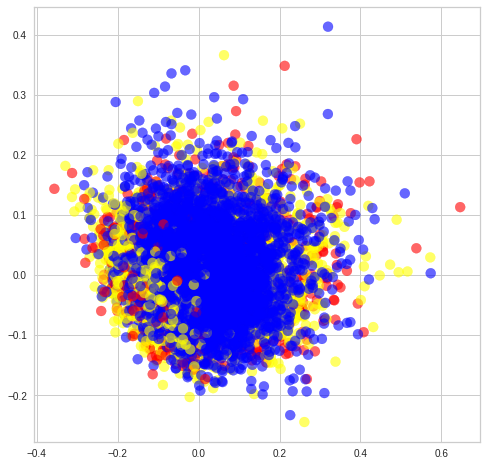

In [71]:
from sklearn.decomposition import PCA
X = new_df.iloc[:, :-2].copy()

#####PLOT#####
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(8, 8))
# plot data
pca = PCA(n_components=2).fit(X)
pca_c = pca.transform(X)
plt.scatter(pca_c[:, 0], pca_c[:, 1], c=new_df.c, alpha=0.6, s=100)


plt.show()

In [52]:
#file_name, n, th_dec_eff, th_eff = select_graph(2)
#models, epochs, k, path, graph_name = get_config(file_name)
file_name, n, th_dec_eff, th_eff = select_graph(3)
models, epochs, k, path, graph_name = get_config(file_name)

for m in models: #models:  ['TransH']
    precision = 0
    recall = 0
    f_measure = 0
    for i in range(0, k):
        tf_training, triple_train = load_dataset(path, 'train_' + str(i + 1) + '.ttl')
        tf_testing, triple_test = load_dataset(path, 'test_' + str(i + 1) + '.ttl')
        model, results = create_model(tf_training, tf_testing, m, epochs, path, i + 1)
        #model = torch.load(path + m + str(i + 1) + '/trained_model.pkl', map_location='cpu')
        predicted_heads_eff = predict_heads(model, 'ex:hasClassificationEffect', 'ex:effective', tf_testing) #tf_training
        predicted_heads_dec_eff = predict_heads(model, 'ex:hasClassificationEffect', 'ex:decrease_effectiveness',tf_testing)

        threshold, threshold_index = get_threshold(predicted_heads_dec_eff, th_dec_eff)
        precision_dec_eff, tp = get_precision(predicted_heads_dec_eff, threshold_index)
        recall_dec_eff = get_recall(predicted_heads_dec_eff, tp)
        #f_measure_dec_eff = get_f_measure(precision_dec_eff, recall_dec_eff)
            
        #display(tf_testing)
        #predicted_heads_dec_eff.reset_index(inplace=True)
        #predicted_heads_dec_eff.drop(columns=['index'], inplace=True)
        #num_dec_eff = predicted_heads_dec_eff.loc[predicted_heads_dec_eff.in_training == True].shape[0]
        #tp_fp = predicted_heads_dec_eff.iloc[0:num_dec_eff]

        #display('num_dec_eff', num_dec_eff, tp_fp)
        #precision_dec_eff, tp = get_precision(predicted_heads_dec_eff, num_dec_eff-1)
        #recall_dec_eff = get_recall(predicted_heads_dec_eff, tp)
        f_measure_dec_eff = 0
        if (precision_dec_eff + recall_dec_eff) > 0:
            f_measure_dec_eff = get_f_measure(precision_dec_eff, recall_dec_eff)
        
        
        threshold, threshold_index = get_threshold(predicted_heads_eff, th_eff)
        precision_eff, tp = get_precision(predicted_heads_eff, threshold_index)
        recall_eff = get_recall(predicted_heads_eff, tp)
        #f_measure_eff = get_f_measure(precision_eff, recall_eff)
        
        #predicted_heads_eff.reset_index(inplace=True)
        #predicted_heads_eff.drop(columns=['index'], inplace=True)
        #num_eff = predicted_heads_eff.loc[predicted_heads_eff.in_training == True].shape[0]
        #tp_fp = predicted_heads_eff.iloc[0:num_eff]

        #display('num_eff', num_eff, tp_fp)
        #precision_eff, tp = get_precision(predicted_heads_eff, num_eff-1)
        #recall_eff = get_recall(predicted_heads_eff, tp)
        f_measure_eff = 0
        if (precision_eff + recall_eff) > 0:
            f_measure_eff = get_f_measure(precision_eff, recall_eff)
        
        
        precision += (precision_eff + precision_dec_eff) / 2
        recall += (recall_eff + recall_dec_eff) / 2
        f_measure += (f_measure_eff + f_measure_dec_eff) / 2
        # print(precision, recall, f_measure)

    avg_precision = precision / k
    avg_recall = recall / k
    avg_f_measure = f_measure / k
    line = m + ';' + str(th_dec_eff) + ';' + str(th_eff) + ';' + str(avg_precision) + ';' + str(
        avg_recall) + ';' + str(avg_f_measure) + '\n'
    save_statistics(path, line)
    print(line)
    
    #break

INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/124 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.35s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594, num_relations=7, num_triples=17246, inverse_triples=False) to file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM1/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM1
INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/124 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.34s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594, num_relations=7, num_triples=17246, inverse_triples=False) to file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM2/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM2
INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/124 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594, num_relations=7, num_triples=17246, inverse_triples=False) to file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM3/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM3
INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/124 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.36s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594, num_relations=7, num_triples=17246, inverse_triples=False) to file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM4/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM4
INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/124 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.36s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=4594, num_relations=7, num_triples=17246, inverse_triples=False) to file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM5/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/rivasa/GitHub/Cancer_treatment/Embeddings/G3/UM5


UM;30.645161290322577;69.35483870967742;0.47477272727272724;0.4915282656907641;0.4825912861043563



In [28]:
(102/116+108/116+106/116+105/116+103/116)/5

0.903448275862069

In [31]:
((8/14)+(86/102))/2

0.707282913165266

In [ ]:
# preparing the statistic study using ONLY the test set. The result should change!